In [50]:
pip install efficientnet-pytorch

In [51]:
pip install efficientnet-pytorch==<specific-version>

/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `pip install efficientnet-pytorch==<specific-version>'


In [52]:
pip install shap

In [53]:
import torch
from torch import nn
import torchvision
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.datasets import ImageFolder
import zipfile
from efficientnet_pytorch import EfficientNet
from tqdm.auto import tqdm
import shap
from efficientnet_pytorch import EfficientNet
import os

In [54]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define transformations, including grayscale and augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Path to the root directory of your train and test data in Google Drive
test_data_path = '/content/drive/MyDrive/pytorch/ck+/CK+48 splitted/test_d'
train_data_path = '/content/drive/MyDrive/pytorch/ck+/CK+48 splitted/train_d'

# List of emotion labels
emotion_labels = [
    'anger', 'contempt', 'disgust', 'fear', 'happiness', 'sadness', 'surprise'
]


class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = [os.path.join(root, filename) for filename in os.listdir(root) if filename.endswith(".png")]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        # Manually extract the emotion label from the filename
        emotion_label = image_path.split('/')[-1].split('_')[0]

        # Handle variations in emotion labels
        if emotion_label == 'happy':
            emotion_label = 'happiness'

        # Get the label index from the emotion_labels list
        label = emotion_labels.index(emotion_label)

        return image, label
# Load your custom train and test datasets
train_dataset = CustomDataset(train_data_path, transform=transform)
test_dataset = CustomDataset(test_data_path, transform=transform)

# Create DataLoaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [ ]:
import torchvision.models as model
dir(model)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

In [59]:
# Load EfficientNet model
efficientnet_model = EfficientNet.from_name('efficientnet-b0', num_classes=7)  # Specify the number of classes
efficientnet_state_dict = torch.load('/content/drive/MyDrive/Emotion_Analysis_Model/efficientnet_model.pth', map_location=torch.device('cpu'))
efficientnet_model.load_state_dict(efficientnet_state_dict, strict=False)  # Set strict=False to ignore mismatches
efficientnet_model.eval()

# Load ResNet50 model
resnet50_model = model.resnet50(pretrained=False)
resnet50_model.fc = nn.Linear(resnet50_model.fc.in_features, 7)  # Set the number of classes
resnet50_state_dict = torch.load('/content/drive/MyDrive/Emotion_Analysis_Model/ResNet50.pth', map_location=torch.device('cpu'))
resnet50_model.load_state_dict(resnet50_state_dict, strict=False)  # Set strict=False to ignore mismatches
resnet50_model.eval()

<ipython-input-59-89a6fca92352>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  efficientnet_state_dict = torch.load('/content/drive/MyDrive/Emotion_Analysis_Model/efficien

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [60]:
unique_images = {}
num_labels = 7  # Total number of unique labels in your dataset (change if needed)

# Iterate through the test dataloader to find one image per label
for test_features_batch, test_labels_batch in test_dataloader:
    for i in range(len(test_features_batch)):
        label = test_labels_batch[i].item()

        # Check if we already have an image for this label
        if label not in unique_images:
            unique_images[label] = test_features_batch[i]

        # Stop if we have one image for each label
        if len(unique_images) == num_labels:
            break
    if len(unique_images) == num_labels:
        break

In [61]:
# Convert each image in unique_images to a NumPy array for further processing
example_images_np = {
    label: (image.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
    for label, image in unique_images.items()
}


In [62]:
from torchvision import transforms

# Select a small subset of images for SHAP's background data
background_images = torch.stack(list(unique_images.values())[:5]).to(device)  # Use fewer images to reduce computation

In [65]:
# Step 3: Define the prediction function for SHAP
def predict_fn(images):
    # Convert list of images to tensor batch
    images = [transforms.ToTensor()(image).unsqueeze(0).to(device) for image in images]
    batch = torch.cat(images).to(device)
    with torch.no_grad():
        # Apply softmax to get probabilities if the model outputs logits
        logits = efficientnet_model(batch)
        probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.cpu().numpy()


**SHAP on Efficientnet Model**

In [69]:
efficientnet_model.to(device)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [75]:
# Step 4: Create a SHAP DeepExplainer
explainer1 = shap.GradientExplainer(efficientnet_model, background_images)

In [92]:
# Step 5: Generate SHAP values for each unique image
shap_values_dict1 = {}
for label, image in unique_images.items():
    input_image = image.unsqueeze(0).to(device)  # Add batch dimension
    shap_values = explainer1.shap_values(input_image)
    shap_values_dict1[label] = shap_values


/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: MemoryEfficientSwish
  warnings.warn(f'unrecognized nn.Module: {module_type}')
/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: Identity
  warnings.warn(f'unrecognized nn.Module: {module_type}')
/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: ZeroPad2d
  warnings.warn(f'unrecognized nn.Module: {module_type}')


SHAP values shape for label 5: (224, 224, 7)


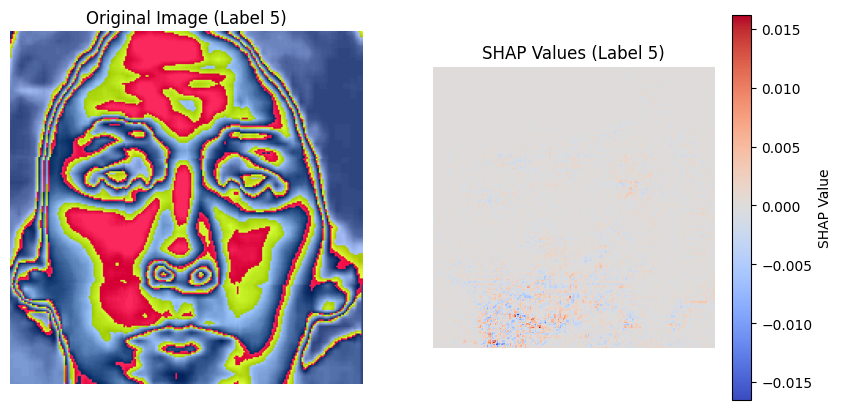

SHAP values shape for label 1: (224, 224, 7)


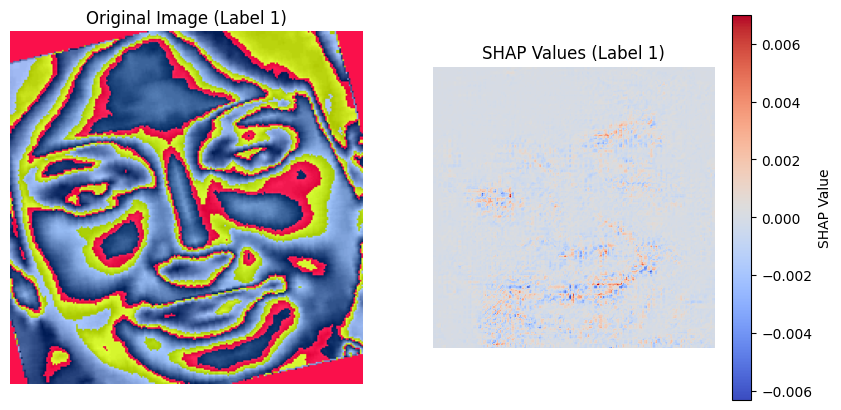

SHAP values shape for label 3: (224, 224, 7)


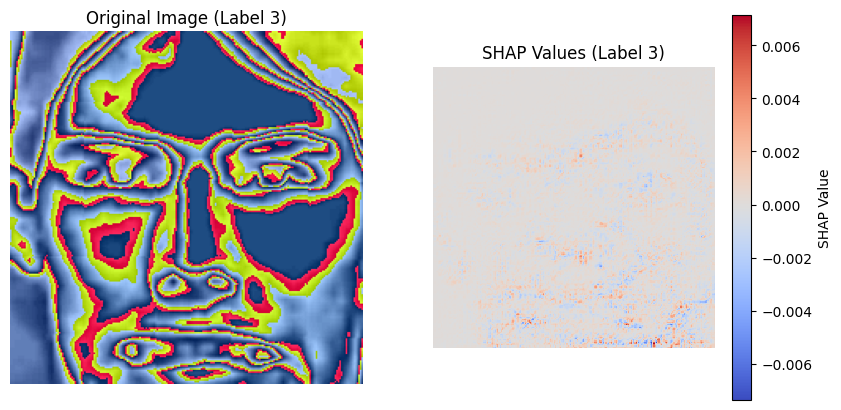

SHAP values shape for label 0: (224, 224, 7)


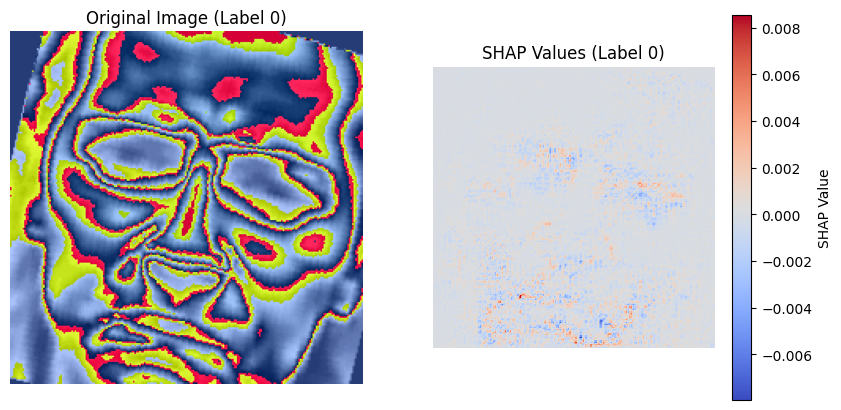

SHAP values shape for label 2: (224, 224, 7)


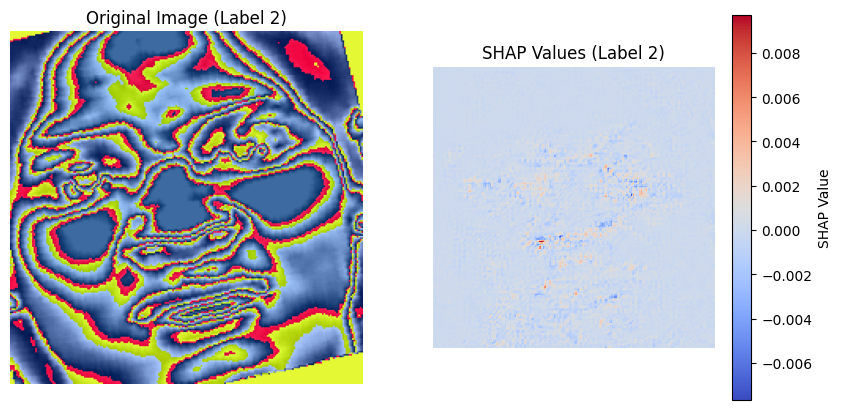

SHAP values shape for label 4: (224, 224, 7)


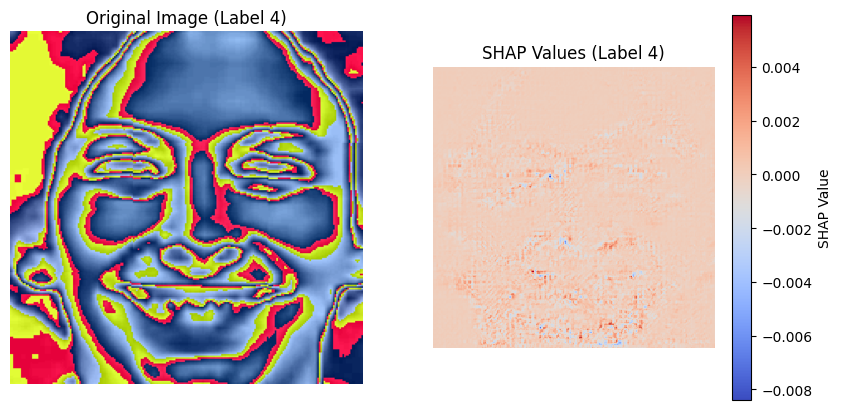

SHAP values shape for label 6: (224, 224, 7)


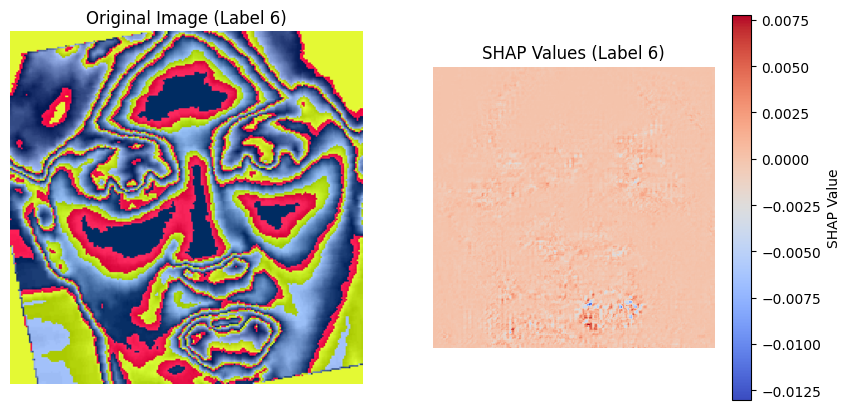

In [93]:
# Step 6: Visualize SHAP values without overlay
for label, shap_values in shap_values_dict1.items():
    shap_image = shap_values[0][0]  # Get the SHAP values for the first output class
    example_image = example_images_np[label]

    # Check the shape of shap_image
    print(f"SHAP values shape for label {label}: {shap_image.shape}")

    # Reduce dimensions if needed
    if shap_image.shape[-1] == 7:  # If there are 7 channels
        shap_image = np.mean(shap_image, axis=-1)  # Take the mean across the channels

    # Create a figure to show the image and its SHAP values
    plt.figure(figsize=(10, 5))

    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.imshow(example_image)
    plt.title(f"Original Image (Label {label})")
    plt.axis('off')

    # Plot the SHAP values without heat overlay
    plt.subplot(1, 2, 2)
    plt.imshow(shap_image, cmap='coolwarm', interpolation='none')
    plt.colorbar(label='SHAP Value')
    plt.title(f"SHAP Values (Label {label})")
    plt.axis('off')

    plt.show()


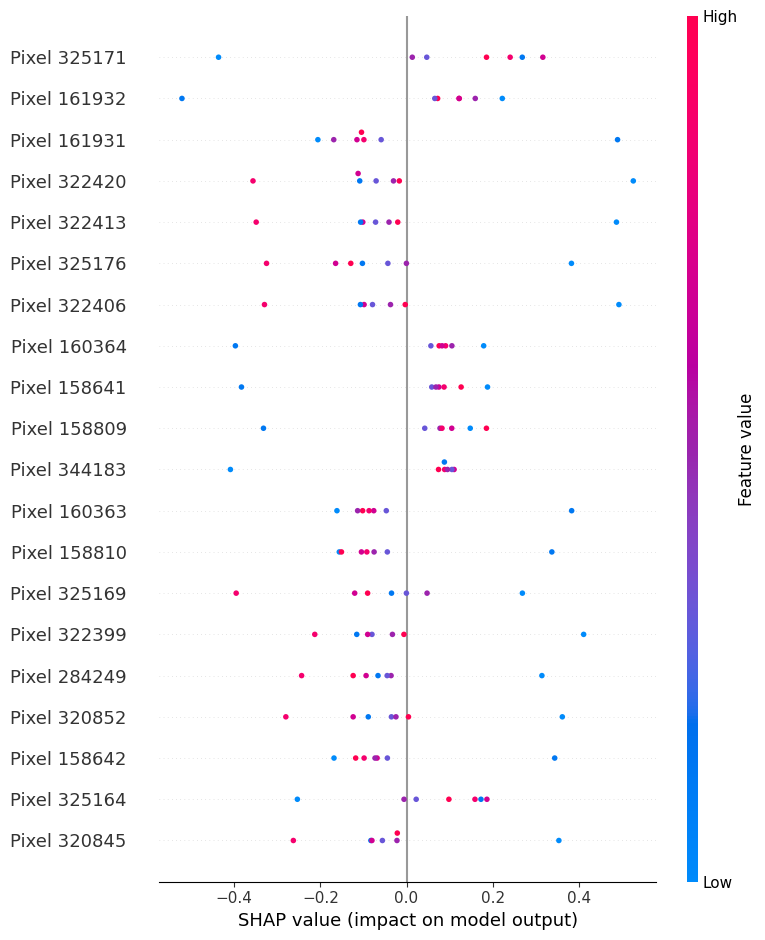

In [98]:
import numpy as np
import shap
import matplotlib.pyplot as plt

# Step 7: Prepare data for summary plot
shap_values_list = []  # This will hold all the SHAP values for the summary plot

for label, shap_values in shap_values_dict1.items():
    shap_image = shap_values[0][0]  # Get the SHAP values for the first output class
    shap_values_list.append(shap_image.flatten())  # Flatten the SHAP image and add to the list

# Convert the list of SHAP values to a 2D numpy array
shap_values_matrix = np.array(shap_values_list)

# Create a DataFrame to organize the data for the summary plot
import pandas as pd

# If you want to show the labels in the summary plot, use the following code:
# Create a DataFrame with the same number of rows as shap_values_matrix and corresponding labels
labels = np.array(list(unique_images.keys()))  # Assuming you want to show labels for the images
num_pixels = shap_values_matrix.shape[1]
label_matrix = np.tile(labels[:, np.newaxis], (1, num_pixels))  # Repeat labels to match the shape of SHAP values

# Plot the SHAP summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_matrix, features=label_matrix, plot_type="dot", feature_names=[f'Pixel {i}' for i in range(num_pixels)])


**SHAP on Resnet50 Model**

In [80]:
resnet50_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [84]:
# Step 4: Create a SHAP DeepExplainer
explainer2 = shap.GradientExplainer(resnet50_model, background_images)

In [94]:
# Step 5: Generate SHAP values for each unique image
shap_values_dict2 = {}
for label, image in unique_images.items():
    input_image = image.unsqueeze(0).to(device)  # Add batch dimension
    shap_values = explainer2.shap_values(input_image)
    shap_values_dict2[label] = shap_values


SHAP values shape for label 5: (224, 224, 7)


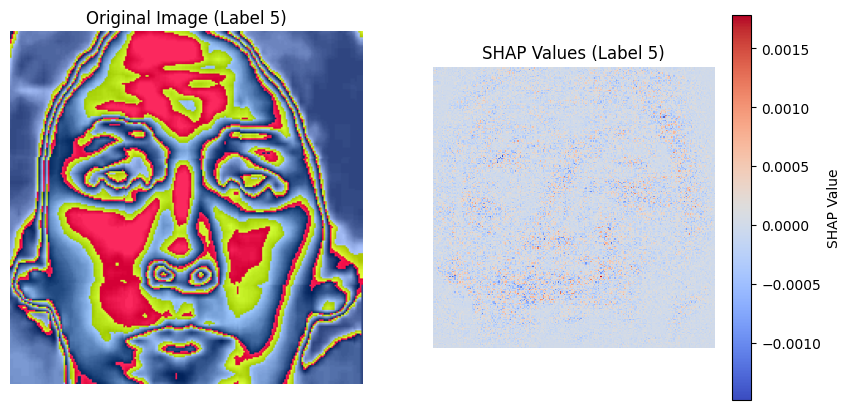

SHAP values shape for label 1: (224, 224, 7)


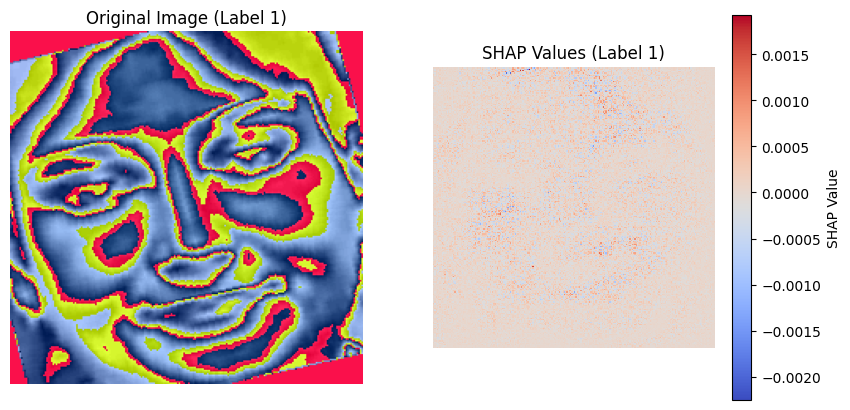

SHAP values shape for label 3: (224, 224, 7)


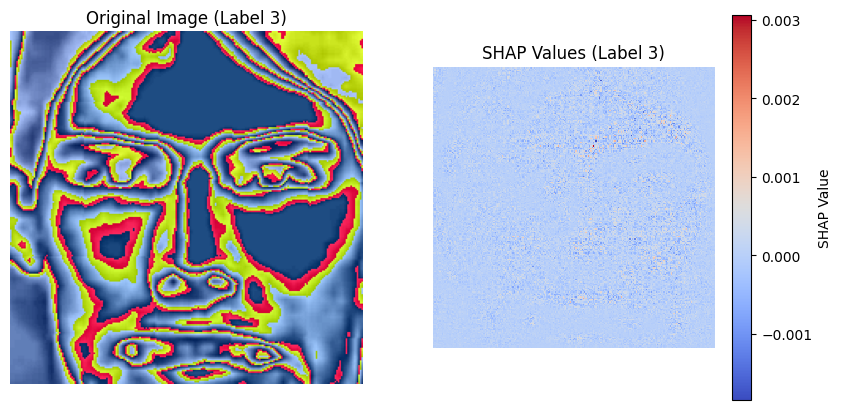

SHAP values shape for label 0: (224, 224, 7)


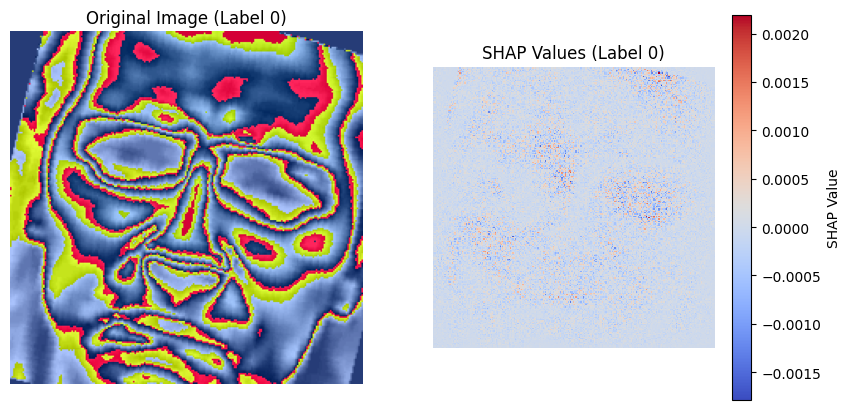

SHAP values shape for label 2: (224, 224, 7)


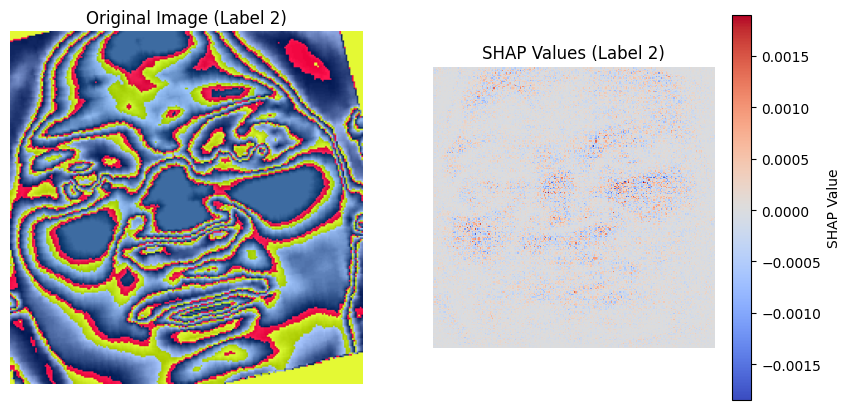

SHAP values shape for label 4: (224, 224, 7)


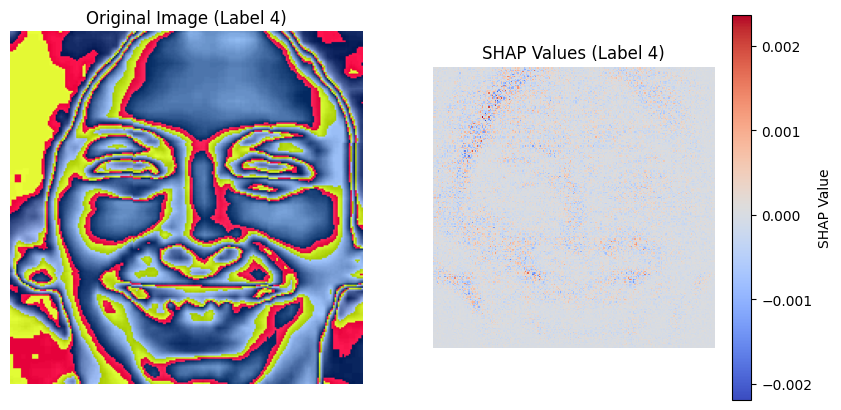

SHAP values shape for label 6: (224, 224, 7)


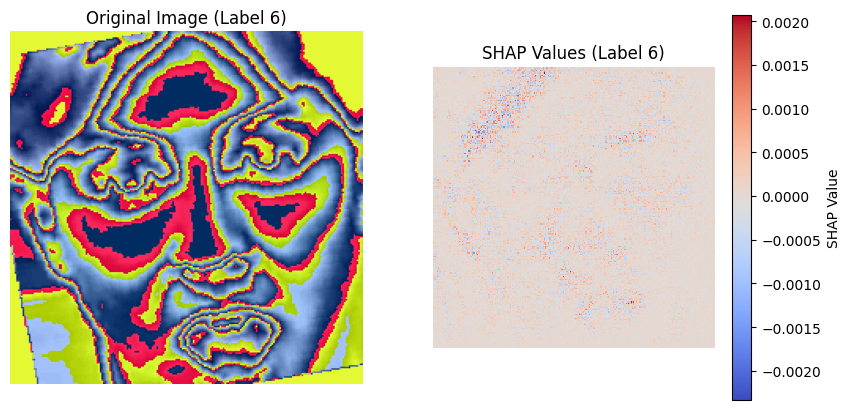

In [95]:
# Step 6: Visualize SHAP values without overlay
for label, shap_values in shap_values_dict2.items():
    shap_image = shap_values[0][0]  # Get the SHAP values for the first output class
    example_image = example_images_np[label]

    # Check the shape of shap_image
    print(f"SHAP values shape for label {label}: {shap_image.shape}")

    # Reduce dimensions if needed
    if shap_image.shape[-1] == 7:  # If there are 7 channels
        shap_image = np.mean(shap_image, axis=-1)  # Take the mean across the channels

    # Create a figure to show the image and its SHAP values
    plt.figure(figsize=(10, 5))

    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.imshow(example_image)
    plt.title(f"Original Image (Label {label})")
    plt.axis('off')

    # Plot the SHAP values without heat overlay
    plt.subplot(1, 2, 2)
    plt.imshow(shap_image, cmap='coolwarm', interpolation='none')
    plt.colorbar(label='SHAP Value')
    plt.title(f"SHAP Values (Label {label})")
    plt.axis('off')

    plt.show()


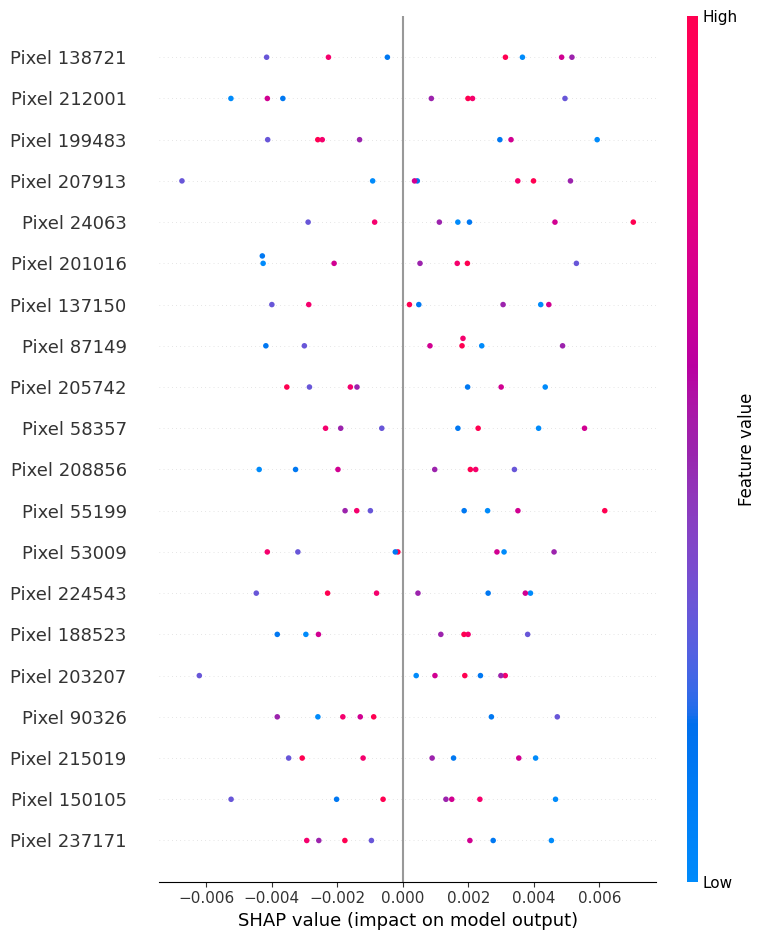

In [99]:
import numpy as np
import shap
import matplotlib.pyplot as plt

# Step 7: Prepare data for summary plot
shap_values_list = []  # This will hold all the SHAP values for the summary plot

for label, shap_values in shap_values_dict2.items():
    shap_image = shap_values[0][0]  # Get the SHAP values for the first output class
    shap_values_list.append(shap_image.flatten())  # Flatten the SHAP image and add to the list

# Convert the list of SHAP values to a 2D numpy array
shap_values_matrix = np.array(shap_values_list)

# Create a DataFrame to organize the data for the summary plot
import pandas as pd

# If you want to show the labels in the summary plot, use the following code:
# Create a DataFrame with the same number of rows as shap_values_matrix and corresponding labels
labels = np.array(list(unique_images.keys()))  # Assuming you want to show labels for the images
num_pixels = shap_values_matrix.shape[1]
label_matrix = np.tile(labels[:, np.newaxis], (1, num_pixels))  # Repeat labels to match the shape of SHAP values

# Plot the SHAP summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_matrix, features=label_matrix, plot_type="dot", feature_names=[f'Pixel {i}' for i in range(num_pixels)])
